In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
# import textblob
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import string
import re
import spacy
import gensim
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('../topic_data.csv')

In [3]:
df_copy = df.copy()

In [4]:
df_copy.describe()

,raw_text_length,year,month,cleaned_text_length
count,4568.000000,4568.0,4568.000000,4568.000000
mean,27.330560,2023.0,3.703590,24.769483
std,11.840659,0.0,0.456724,11.581002
min,1.000000,2023.0,3.000000,1.000000
25%,17.000000,2023.0,3.000000,15.000000
50%,27.000000,2023.0,4.000000,24.000000
75%,37.000000,2023.0,4.000000,34.000000
max,61.000000,2023.0,4.000000,57.000000


In [5]:
df_copy.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4568 entries, 0 to 4567
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   text                 4568 non-null   object
 1   date                 4568 non-null   object
 2   raw_text_length      4568 non-null   int64 
 3   year                 4568 non-null   int64 
 4   month                4568 non-null   int64 
 5   cleaned_text         4568 non-null   object
 6   cleaned_text_length  4568 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 3.2 MB


**Memory management**

In [6]:
# Memory management
def memory_magment(df):
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != np.object:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8) # int 8
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16) # int 16
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)  # in 32
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64) # int 64 
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else: 
                    df[col] = df[col].astype(np.float64)
    return df
df_memory = df_copy.copy()
df_memory = memory_magment(df_memory)    

In [7]:
df_memory.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4568 entries, 0 to 4567
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   text                 4568 non-null   object
 1   date                 4568 non-null   object
 2   raw_text_length      4568 non-null   int8  
 3   year                 4568 non-null   int16 
 4   month                4568 non-null   int8  
 5   cleaned_text         4568 non-null   object
 6   cleaned_text_length  4568 non-null   int8  
dtypes: int16(1), int8(3), object(3)
memory usage: 3.1 MB


Memory reduced from 3.2 --> 3.1 MB

**Preprocessing the data to obtain the tokens.**

- The cleaned_text version will be made use of for this process.

In [8]:
df_memory.sample(n=2,random_state=42)

,text,date,raw_text_length,year,month,cleaned_text,cleaned_text_length
1552,US SB 686 | Real-World Ministry of Truth Being...,2023-03-28 15:35:04+00:00,15,2023,3,us sb real world ministry of truth being estab...,14
23,Exclusive — Rep. Jeff Van Drew: Democrats Afra...,2023-04-03 10:56:07+00:00,20,2023,4,exclusive rep jeff van drew democrats afraid d...,17


In [9]:
featured_data = df_memory[['cleaned_text']]

In [10]:
featured_data

,cleaned_text
0,ah yes just love waking up to the sweet aroma...
1,when flies to georgia to take part in protest ...
2,exclusive rep jeff van drew democrats afraid o...
3,it april at pm stop your period pain instantly...
4,pmatcbidiamondjubilee corruption and dynastic...
...,...
4563,if the word cannot provoke you to preach the g...
4564,cept my own and that of the manager my name pr...
4565,graham potter chelsea exit set for huge impact...
4566,how to watch manchester united vs brentford us...


In [14]:
from spacy.lang.en.stop_words import STOP_WORDS

all_stopwords = STOP_WORDS
my_stop_words = set(all_stopwords) # My own stop words

In [15]:
nlp = spacy.load("en_core_web_sm")

def spacy_tokeniser(sent):
    sent = sent.strip().lower()
    doc = nlp(sent)
    mytokens = [token.lemma_ for token in doc if token.text not in my_stop_words]
    return mytokens

featured_data['tokens'] = featured_data['cleaned_text'].apply(spacy_tokeniser)

In [16]:
# Compute bigrams
from gensim.models import Phrases
from gensim.models.phrases import Phraser,ENGLISH_CONNECTOR_WORDS

In [17]:
docs = featured_data['tokens'].tolist()

In [18]:
# docs

In [19]:
docs[0][:8] # from document 1

['ah', 'yes', 'love', 'wake', 'sweet', 'aroma', 'political', 'chaos']

In [20]:
# Add bigrams to docs (only ones that appear 20 times or more).
# https://stackoverflow.com/questions/35716121/how-to-extract-phrases-from-corpus-using-gensim
# https://radimrehurek.com/gensim/models/phrases.html#gensim.models.phrases.original_scorer
# This is usisng the default scorer and not the robust scorer; npmi
bigram_phrases = Phrases(docs, min_count=20,connector_words=ENGLISH_CONNECTOR_WORDS)

In [21]:
bigram = Phraser(bigram_phrases)

In [22]:
def make_bigram(texts):
    return([bigram[doc] for doc in texts])

In [23]:
bigrams_docs = make_bigram(docs)

In [24]:
print(bigrams_docs[200][:])

['exclusive_rep', 'jeff_van', 'draw_democrats', 'afraid_donald', 'trump_corruption', 'win']


In [25]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
id2word = Dictionary(bigrams_docs)
# or 
# dictionary = Dictionary(docs)


# Filter out words that occur less than 20 documents, or more than 50% of the documents.
# https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.filter_extremes
id2word.filter_extremes(no_below=20, no_above=0.5)

In [26]:
# id2word.most_common(20) # most common words
# [('ai', 1005),
#  ('healthcare', 719),
#  ('usa', 594),
#  ('amp', 528),
#  ('corruption', 525),
#  ('truth', 516),
#  ('disaster', 455),
#  ('virus', 413),
#  ('manager', 387),
#  ('politic', 343),
#  ('football', 317),
#  ('new', 261),
#  ('world', 211),
#  ('like', 200),
#  ('people', 191),
#  ('trump', 186),
#  ('time', 182),
#  ('datum_science', 180),
#  ('machine_learn', 170),
#  ('win', 169)]

In [27]:
# Bag-of-words representation of the documents.
# Term document frequency 
bow_corpus = [id2word.doc2bow(doc) for doc in bigrams_docs]

In [28]:
# Create corpus
texts = bigrams_docs

In [29]:
print(f'Number of unique tokens: { len(id2word)}')
print(f'Number of documents: {len(bow_corpus)}')

Number of unique tokens: 629
Number of documents: 4568


In [27]:
print(df_memory.loc[200,'text'])
print(featured_data.loc[200,"cleaned_text"])
print(featured_data.loc[200,"tokens"])

Exclusive — Rep. Jeff Van Drew: Democrats Afraid Donald Trump Will Take Out 'Corruption' if He Wins in 2024 https://t.co/A8CzILhxt0
exclusive rep jeff van drew democrats afraid donald trump will take out corruption if he wins in 
['exclusive', 'rep', 'jeff', 'van', 'draw', 'democrats', 'afraid', 'donald', 'trump', 'corruption', 'win']


In [28]:
# Verifying BOW is set up correctly
print(f" Cleaned Text: \n{featured_data.loc[200,'cleaned_text']}")
print(f"Bow representation: {bow_corpus[200]}")

document_200 = bow_corpus[200]
for i in range(len(document_200)):
    print(f"Word {document_200[i][0]}, {id2word[document_200[i][0]]}, appears {document_200[i][1]}")

 Cleaned Text: 
exclusive rep jeff van drew democrats afraid donald trump will take out corruption if he wins in 
Bow representation: [(10, 1), (11, 1), (12, 1), (40, 1), (45, 1), (46, 1)]
Word 10, draw_democrats, appears 1
Word 11, exclusive_rep, appears 1
Word 12, jeff_van, appears 1
Word 40, afraid_donald, appears 1
Word 45, trump_corruption, appears 1
Word 46, win, appears 1


### **Determining best number of topics**

In [29]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from gensim import models
from gensim.models.coherencemodel import CoherenceModel

[Link](https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html)

**chunksize** controls how many documents are processed at a time in the training algorithm. Increasing chunksize will speed up training, at least as long as the chunk of documents easily fit into memory.

**passes** controls how often we train the model on the entire corpus. Another word for passes might be “epochs”. 

**iterations** is somewhat technical, but essentially it controls how often we repeat a particular loop over each document. It is important to set the number of “passes” and “iterations” high enough.

In [30]:
def compute_coherence_scores(corpus, dictionary,k,a=None,b=None):
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                            num_topics=k,
                                            id2word=dictionary,
                                            chunksize=2000,
                                            passes=50,
                                            iterations=400,
                                            random_state=42,
                                            workers=2,
                                            eval_every = None 
                                            # Don't evaluate model perplexity, takes too much time.
                                            )

    coherence_model_lda = CoherenceModel(model=lda_model,
                                        # texts=texts,
                                        corpus=corpus,
                                        dictionary=dictionary,
                                        coherence="u_mass",
                                        processes=-2)                            
                                                                    

    return coherence_model_lda.get_coherence()

In [31]:
model_results = {
    "topics": [],
    "coherence_score": [],
}

start = 2
stop = 10

In [32]:
# iterate through number of topics
for k in range(start,stop+1):
            score = compute_coherence_scores(corpus=bow_corpus,
                                        dictionary=id2word,
                                        k=k,
                                        )

            model_results["topics"].append(k) 
            model_results["coherence_score"].append(score) 

In [33]:
model_results_frame = pd.DataFrame(model_results)
model_results_frame.to_csv("model_versions/results/bigrams_results_umass.csv", index=False)

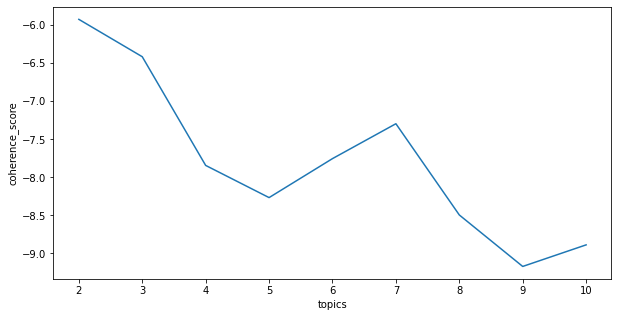

In [34]:
fig,ax = plt.subplots(figsize=(10,5))
sns.lineplot(data=model_results_frame,x='topics',y="coherence_score")
plt.show()

In [35]:
zipped_values = zip(*model_results.values())
print(list(zipped_values))

[(2, -5.923911531849572), (3, -6.415025224463654), (4, -7.843012108282332), (5, -8.265891357203284), (6, -7.753680075547357), (7, -7.295302739138853), (8, -8.49396409752368), (9, -9.170447152814841), (10, -8.886901039516049)]


In [36]:
coherence_scores = []
for topic, coherence_score in zip(*model_results.values()):
    print(f"Topic {topic} has a coherence_score of {coherence_score}")
    coherence_scores.append(coherence_score)

Topic 2 has a coherence_score of -5.923911531849572
Topic 3 has a coherence_score of -6.415025224463654
Topic 4 has a coherence_score of -7.843012108282332
Topic 5 has a coherence_score of -8.265891357203284
Topic 6 has a coherence_score of -7.753680075547357
Topic 7 has a coherence_score of -7.295302739138853
Topic 8 has a coherence_score of -8.49396409752368
Topic 9 has a coherence_score of -9.170447152814841
Topic 10 has a coherence_score of -8.886901039516049


In [37]:
coherence_scores[np.argmin(coherence_scores,axis=0)] 

-9.170447152814841

Overall best score is topic 9, but we would explore 9, 8, 6 and 5 topics.

*Kindly note that pyLDAvis topics numbering starts from 1, so topic 1 is 0, etc*

In [38]:
optimal_model_nine = gensim.models.LdaMulticore(corpus=bow_corpus,
                                            num_topics=9,
                                            id2word=id2word,
                                            chunksize=2000,
                                            passes=50,
                                            iterations=400,
                                            random_state=42,
                                            workers=2,)

In [41]:
# model_topics = optimal_model.show_topics(formatted=False)
optimal_model_nine.print_topics(num_words=20)

[(0,
  '0.046*"game" + 0.042*"player" + 0.035*"messi" + 0.032*"season" + 0.027*"new" + 0.024*"manager" + 0.022*"win" + 0.020*"check" + 0.020*"chatgpt" + 0.020*"united" + 0.018*"make" + 0.016*"lose" + 0.016*"gt" + 0.016*"announce" + 0.015*"hit" + 0.014*"live" + 0.013*"role" + 0.013*"head" + 0.013*"contract" + 0.013*"digitalhealth"'),
 (1,
  '0.072*"manager" + 0.068*"chelsea" + 0.032*"football" + 0.026*"man" + 0.024*"graham_potter" + 0.022*"sack" + 0.019*"liverpool" + 0.019*"day" + 0.015*"coach" + 0.015*"city" + 0.015*"fan" + 0.015*"come" + 0.015*"news" + 0.014*"week" + 0.014*"look" + 0.011*"real" + 0.011*"available" + 0.011*"amp" + 0.011*"season" + 0.011*"career"'),
 (2,
  '0.063*"usa" + 0.056*"corruption" + 0.054*"truth" + 0.037*"politic" + 0.028*"amp" + 0.019*"trump" + 0.017*"nigeriadecide" + 0.013*"people" + 0.011*"world" + 0.011*"country" + 0.010*"government" + 0.010*"president" + 0.010*"election" + 0.010*"china" + 0.009*"lie" + 0.009*"biden" + 0.009*"news" + 0.008*"medium" + 0.008*

### **Visualising the topics**

In [40]:
# visualise the topics
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
pyLDAvis.enable_notebook()
# pyLDAvis.enable_notebook(local=True)
vis_data_nine = gensimvis.prepare(optimal_model_nine,bow_corpus,id2word, sort_topics=False)
pyLDAvis.save_html(vis_data_nine, 'topic_visuals_bigrams/topics_of_9.html')
pyLDAvis.display(vis_data_nine)

**Observations**

Based off the plot the following could be observed:
- There is some overlap between topics 3 & 4, and 1,2,7 & 9.
- Lower number of topics should be experimented with.

In [43]:
optimal_model_eight = gensim.models.LdaMulticore(corpus=bow_corpus,
                                            num_topics=8,
                                            id2word=id2word,
                                            chunksize=2000,
                                            passes=50,
                                            iterations=400,
                                            random_state=42,
                                            workers=2,)

In [44]:
# model_topics = optimal_model.show_topics(formatted=False)
optimal_model_eight.print_topics(num_words=20)

[(0,
  '0.115*"ai" + 0.086*"healthcare" + 0.026*"manager" + 0.026*"new" + 0.022*"post" + 0.020*"amp" + 0.017*"site" + 0.016*"technology" + 0.016*"artificialintelligence" + 0.015*"web" + 0.015*"industry" + 0.015*"quality" + 0.014*"publish" + 0.013*"cross" + 0.012*"patient" + 0.011*"datum" + 0.011*"chatgpt" + 0.011*"healthtech" + 0.010*"tech" + 0.010*"innovation"'),
 (1,
  '0.162*"manager" + 0.062*"chelsea" + 0.036*"job" + 0.031*"season" + 0.022*"graham_potter" + 0.020*"sack" + 0.020*"new" + 0.018*"look" + 0.018*"liverpool" + 0.017*"man" + 0.017*"fan" + 0.015*"game" + 0.014*"city" + 0.013*"news" + 0.013*"come" + 0.012*"club" + 0.012*"messi" + 0.012*"like" + 0.011*"announce" + 0.011*"lose"'),
 (2,
  '0.058*"usa" + 0.052*"corruption" + 0.050*"truth" + 0.035*"politic" + 0.027*"amp" + 0.018*"trump" + 0.016*"nigeriadecide" + 0.012*"people" + 0.011*"government" + 0.010*"country" + 0.009*"election" + 0.009*"president" + 0.009*"news" + 0.008*"biden" + 0.008*"world" + 0.008*"america" + 0.008*"mon

### **Visualising the topics**

In [45]:
pyLDAvis.enable_notebook()
# pyLDAvis.enable_notebook(local=True)
vis_data_eight = gensimvis.prepare(optimal_model_eight,bow_corpus,id2word, sort_topics=False)
pyLDAvis.save_html(vis_data_eight, 'topic_visuals_bigrams/topics_of_8.html')
pyLDAvis.display(vis_data_eight)
# https://github.com/DistrictDataLabs/yellowbrick/issues/570
# 1. saliency
# 2. Relevance

**Observations**

Based off the plot the following could be observed:
- Topic 1 is talking about data science, AI & health tech.
- Topic 8 is somewhat an overlap of politics and words related to topic 1.
- Topic 4 could be talking about sports while topic 3 is about politics.
- Topic 7 is mosty about sports, same with topics 5 and 2.
- Topic 6 is about politics
- Lower number of topics should be experimented with.

In [46]:
optimal_model_six = gensim.models.LdaMulticore(corpus=bow_corpus,
                                            num_topics=6,
                                            id2word=id2word,
                                            chunksize=2000,
                                            passes=50,
                                            iterations=400,
                                            random_state=42,
                                            workers=2,)

In [53]:
optimal_model_six.print_topics(num_words=50)

[(0,
  '0.102*"ai" + 0.076*"healthcare" + 0.018*"amp" + 0.015*"goal" + 0.015*"technology" + 0.014*"artificialintelligence" + 0.012*"industry" + 0.011*"future" + 0.011*"patient" + 0.010*"health" + 0.010*"datum" + 0.010*"care" + 0.010*"chatgpt" + 0.009*"healthtech" + 0.009*"innovation" + 0.009*"machinelearne" + 0.008*"tech" + 0.008*"check" + 0.007*"medical" + 0.007*"read" + 0.007*"gt_gt" + 0.007*"transform" + 0.007*"change" + 0.007*"improve" + 0.006*"thank" + 0.006*"tool" + 0.006*"digitalhealth" + 0.006*"great" + 0.006*"datascience" + 0.006*"digital" + 0.006*"artificial_intelligence" + 0.006*"ai_ml" + 0.006*"learn" + 0.005*"increase" + 0.005*"truth_social" + 0.005*"use" + 0.005*"impact" + 0.005*"power" + 0.005*"way" + 0.005*"education" + 0.005*"article" + 0.005*"blockchain" + 0.005*"new" + 0.005*"risk" + 0.005*"research" + 0.005*"instantly_naturally" + 0.005*"thepeoplestownhall" + 0.005*"nuvapad_drug" + 0.005*"well_click" + 0.005*"obidatti_nigeriadecide"'),
 (1,
  '0.055*"manager" + 0.04

### **Visualising the topics**

In [48]:
pyLDAvis.enable_notebook()
# pyLDAvis.enable_notebook(local=True)
vis_data_six = gensimvis.prepare(optimal_model_six,bow_corpus,id2word, sort_topics=False)
pyLDAvis.save_html(vis_data_six, 'topic_visuals_bigrams/topics_of_6.html')
pyLDAvis.display(vis_data_six)

**Observations**

Based off the plot the following could be observed:
- Topics 5, 4 & 2 seems to be talking about sports and maybe disaster; topics 4 and 2 are closer to sports while 5 is closer to disaster
- Topic 6 is closer to politics and ai.
- Topic 3 is closer to politics.
- Topic 1 is close to ai and healthcare.

In [49]:
optimal_model_five = gensim.models.LdaMulticore(corpus=bow_corpus,
                                            num_topics=5,
                                            id2word=id2word,
                                            chunksize=2000,
                                            passes=50,
                                            iterations=400,
                                            random_state=42,
                                            workers=2,)

In [52]:
optimal_model_five.print_topics(num_words=50)

[(0,
  '0.086*"ai" + 0.062*"healthcare" + 0.018*"new" + 0.017*"post" + 0.015*"datum_science" + 0.015*"amp" + 0.014*"manager" + 0.014*"machine_learn" + 0.014*"quality" + 0.013*"web" + 0.013*"goal" + 0.013*"site" + 0.012*"technology" + 0.012*"datum" + 0.011*"artificialintelligence" + 0.011*"industry" + 0.010*"learn" + 0.010*"care" + 0.010*"machine_learning" + 0.010*"publish" + 0.010*"share" + 0.010*"cross" + 0.009*"future" + 0.009*"chatgpt" + 0.009*"patient" + 0.008*"read" + 0.008*"data_science" + 0.008*"healthtech" + 0.008*"health" + 0.007*"innovation" + 0.007*"datascience" + 0.007*"machinelearne" + 0.007*"artificial_intelligence" + 0.007*"tech" + 0.006*"improve" + 0.006*"medical" + 0.006*"transform" + 0.005*"tool" + 0.005*"digitalhealth" + 0.005*"fight_corruption" + 0.005*"information" + 0.005*"use" + 0.005*"turn_washington" + 0.005*"congo_mining" + 0.005*"gt_gt" + 0.005*"riches_take" + 0.005*"change" + 0.005*"ai_ml" + 0.005*"article" + 0.004*"machinelearning"'),
 (1,
  '0.066*"manager

### **Visualising the topics**

In [51]:
pyLDAvis.enable_notebook()
# pyLDAvis.enable_notebook(local=True)
vis_data_five = gensimvis.prepare(optimal_model_five,bow_corpus,id2word, sort_topics=False)
pyLDAvis.save_html(vis_data_five, 'topic_visuals_bigrams/topics_of_5.html')
pyLDAvis.display(vis_data_five)

**Observations**

Based off the plot the following could be observed:
- Now topic 1 is focused on ai and healthcare.
- Topics 5 and 2 is related to sports, but topic 5 could be related to disaster while 2 is related more to sports.
- Topic 3 is related to politics.
- Topic 4 reelated to sports.

Best to move on with a model of 6 topics.

In [55]:
# Savming the model: Topics of 6
# optimal_model_six.save("model_versions/saved_models/bigrams/topics_of_6_.model")

In [12]:
from gensim import models
# Loading the model
my_model = gensim.models.LdaMulticore.load("model_versions/saved_models/bigrams/topics_of_6_.model")
my_model.print_topics(num_words=20)

[(0,
  '0.102*"ai" + 0.076*"healthcare" + 0.018*"amp" + 0.015*"goal" + 0.015*"technology" + 0.014*"artificialintelligence" + 0.012*"industry" + 0.011*"future" + 0.011*"patient" + 0.010*"health" + 0.010*"datum" + 0.010*"care" + 0.010*"chatgpt" + 0.009*"healthtech" + 0.009*"innovation" + 0.009*"machinelearne" + 0.008*"tech" + 0.008*"check" + 0.007*"medical" + 0.007*"read"'),
 (1,
  '0.055*"manager" + 0.045*"chelsea" + 0.039*"football" + 0.030*"game" + 0.028*"messi" + 0.020*"season" + 0.019*"player" + 0.016*"get" + 0.016*"man" + 0.016*"graham_potter" + 0.014*"look" + 0.014*"fan" + 0.014*"club" + 0.013*"psg" + 0.013*"league" + 0.013*"win" + 0.013*"like" + 0.013*"liverpool" + 0.012*"news" + 0.012*"match"'),
 (2,
  '0.051*"usa" + 0.046*"corruption" + 0.044*"truth" + 0.031*"amp" + 0.031*"politic" + 0.018*"people" + 0.016*"trump" + 0.015*"day" + 0.014*"nigeriadecide" + 0.009*"country" + 0.009*"don" + 0.008*"medium" + 0.008*"election" + 0.008*"president" + 0.008*"government" + 0.008*"news" + 0.

### **Appending the topics to the documents**

In [76]:
# range_list = [
#     [(2, 0.32421985), (5, 0.62066925), (7, 0.92066925),(8, 0.72066925)],
#     [(5, 0.7632791), (8, 0.92066925)]
#  ]

In [77]:
# # expr for val in collection if condition]
# new  = [[item[0] for item in inner if item[1] > 0.5] for inner in range_list]

# new

In [78]:
# topic = []
# for inner in range_list:
#     sub_list = []
#     for item in inner:
#         if item[1] > 0.5:
#             sub_list.append(item[0])
#     topic.append(sub_list)
#     print(sub_list)

In [30]:
# lda_corpus = optimal_model_six[bow_corpus]
lda_corpus = my_model[bow_corpus]

In [31]:
topics_list = list(lda_corpus)

In [32]:
# Trying to filter the probabilities of documents relating to a set of topics
topics_to_documents = [[item[0] for item in inner if item[1] > 0.1] for inner in topics_list]
# topics_to_documents = [[item[0] for item in inner if item[1] > 0.5] for inner in topics_list]

In [33]:
count = 0 
for i in lda_corpus:
    print(f"Document {count}: Topics: {i}")
    count +=1

Document 0: Topics: [(0, 0.023838624), (1, 0.023975527), (2, 0.8804173), (3, 0.023888012), (4, 0.0240704), (5, 0.023810174)]
Document 1: Topics: [(0, 0.03340938), (1, 0.03333426), (2, 0.83307457), (3, 0.03333426), (4, 0.033334274), (5, 0.033513237)]
Document 2: Topics: [(0, 0.033333752), (1, 0.03333375), (2, 0.03333375), (3, 0.033333752), (4, 0.033333756), (5, 0.8333313)]
Document 3: Topics: [(0, 0.015187535), (1, 0.015152064), (2, 0.015152064), (3, 0.9242042), (4, 0.015152072), (5, 0.015152072)]
Document 4: Topics: [(0, 0.023819251), (1, 0.88091666), (2, 0.023810787), (3, 0.023810795), (4, 0.023831723), (5, 0.023810808)]
Document 5: Topics: [(0, 0.018684307), (1, 0.018543178), (2, 0.30938482), (3, 0.61596054), (4, 0.018531492), (5, 0.01889569)]
Document 6: Topics: [(0, 0.018519687), (1, 0.018600153), (2, 0.40489337), (3, 0.52092904), (4, 0.018525878), (5, 0.01853182)]
Document 7: Topics: [(0, 0.01515215), (1, 0.015184742), (2, 0.3874469), (3, 0.01516115), (4, 0.01518868), (5, 0.551866

In [34]:
clustering  = df_memory[["text", "cleaned_text"]]

In [35]:
clustering["topics"] = topics_to_documents

In [36]:
clustering.head()

,text,cleaned_text,topics
0,"""Ah, yes. I just love waking up to the sweet a...",ah yes just love waking up to the sweet aroma...,[2]
1,When @ViolavonCramon\nflies to Georgia 🇬🇪 to t...,when flies to georgia to take part in protest ...,[2]
2,Exclusive — Rep. Jeff Van Drew: Democrats Afra...,exclusive rep jeff van drew democrats afraid o...,[5]
3,"It’s April 03, 2023 at 12:29PM\nStop Your Peri...",it april at pm stop your period pain instantly...,[3]
4,#PMAtCBIDiamondJubilee\nCorruption and dynasti...,pmatcbidiamondjubilee corruption and dynastic...,[1]


In [37]:
clustering.tail()

,text,cleaned_text,topics
4563,If the Word cannot provoke you to preach the g...,if the word cannot provoke you to preach the g...,[4]
4564,"cept\nmy own and that of the manager.\n\n""'My ...",cept my own and that of the manager my name pr...,"[1, 5]"
4565,Graham Potter's Chelsea exit set for huge impa...,graham potter chelsea exit set for huge impact...,"[0, 1]"
4566,How to watch Manchester United vs Brentford - ...,how to watch manchester united vs brentford us...,[1]
4567,Erik ten Hag has contradicted himself over Wou...,erik ten hag has contradicted himself over wou...,[1]


In [38]:
print(f"Raw Text: {clustering.loc[1383,'text']}\n")
print(f"Cleaned Text: {clustering.loc[1383,'cleaned_text']}\n")
print(f"Topics: {clustering.loc[1383,'topics']}")

Raw Text: Exposing the truth. A great man against the Empire of Lies. Lavrov, a diplomat will mark history. 
Hopefully Russia will stop the decades-long terror of the USA &amp; the NATO pact. Go ahead, Russians, justice is with you. The time of reckoning has come. 

https://t.co/ULYdzexOYr

Cleaned Text: exposing the truth great man against the empire of lies lavrov diplomat will mark history hopefully russia will stop the decades long terror of the usa amp the nato pact go ahead russians justice is with you the time of reckoning has come 

Topics: [1, 2]


In [39]:
print(f"Raw Text: {clustering.loc[258,'text']}\n")
print(f"Cleaned Text: {clustering.loc[258,'cleaned_text']}\n")
print(f"Topics: {clustering.loc[258,'topics']}")

Raw Text: I love my political Daddy! Daddy of Modern Politics. Daddy of Politics without bitterness. Daddy of Issue Based Politics. Daddy of Politics of Competence. Daddy of Politics without corruption. We Love you Daddy, Yes Daddy!

Cleaned Text: i love my political daddy daddy of modern politics daddy of politics without bitterness daddy of issue based politics daddy of politics of competence daddy of politics without corruption we love you daddy yes daddy 

Topics: [2]


In [40]:
print(f"Raw Text: {clustering.loc[1882,'text']}\n")
print(f"Cleaned Text: {clustering.loc[1882,'cleaned_text']}\n")
print(f"Topics: {clustering.loc[1882,'topics']}")

Raw Text: Tweet: 📣 New AI tool alert! 🎉 Check out Buoy Health - an innovative digital health platform that helps users take control of their health with simple online tools &amp; personalized advice. #AiTopTools #DigitalHealth #ProactiveHealth #AI #Healthcare https://t.co/vLMrDiXXzF

Cleaned Text: tweet new ai tool alert check out buoy health an innovative digital health platform that helps users take control of their health with simple online tools amp personalized advice aitoptools digitalhealth proactivehealth ai healthcare 

Topics: [0]


In [41]:
clustering.to_csv("saved_bigrams_clusters_document/clustering.csv")

*Kindly note:*

Mapping the topics to the graph;
- Topics 0 is 1 on the graph.
- Topics 1 is 2 on the graph.
- Topics 2 is 3 on the graph.
- Topics 3 is 4 on the graph.
- Topics 4 is 5 on the graph.
- Topics 5 is 6 on the graph.

Please remember the following observations from the graph for topic 6 but using the index numbering as specified here;
- Topics 4, 3 & 1 seems to be talking about sports and maybe disaster; topics 3 and 1 are closer to sports while 4 is closer to disaster
- Topic 5 is closer to politics and ai.
- Topic 2 is closer to politics.
- Topic 0 is close to ai and healthcare.